Using TensorFlow backend.


# Downloading Data: 

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


##To visualize the dataset: 

0


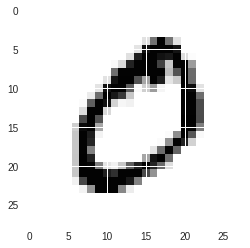

In [0]:
import matplotlib.pyplot as plt 
%matplotlib inline 
image_index=1
print(y_train[image_index])
plt.imshow(x_train[image_index], cmap='Greys')


#Training a GAN on MNIST dataset

Always gets the analogy of the counterfeiter and the police. Counterfeiter attempts to make new fake money on feedback from the police, until police is fooled by fake money generated. 

## The Discriminator v 1.0 (the police)

- essentially consists of a deep convolutional neural network
- differs from a typical CNN due to absence of max-pooling in between layers 
- downsampling is done through a strided convolution 
- Activation function and Dropout layers are used. 
- Dropout: 0.4 to 0.7 between layers prevents overfitting and memorization 

In [0]:
class GAN(object): 
    def __init__(self):
      self.img_rows = 28 
      self.img_cols = 28 
      self.channel=1
       
      
    
    def build_discriminator(self):
      model = Sequential()
      depth = 64 
      dropout=0.4 
      input_shape = (self.img_rows, self.img_cols, self.channel)
      model.add(Conv2D(depth*1, 3, strides=2, input_shape=input_shape, padding='same'))
      model.add(BatchNormalization(momentum=0.8))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dropout(dropout))
      model.add(Conv2D(depth*2, 4, strides=2, padding='same', activation=LeakyReLU(alpha=0.2)))
      model.add(BatchNormalization(momentum=0.8))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dropout(dropout))
      model.add(Conv2D(depth*4, 4, strides=2, padding='same', activation=LeakyReLU(alpha=0.2)))
      model.add(BatchNormalization(momentum=0.8))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dropout(dropout))
      model.add(Conv2D(depth*8, 4, strides=2, padding='same', activation=LeakyReLU(alpha=0.2)))
      model.add(BatchNormalization(momentum=0.8))
      model.add(LeakyReLU(alpha=0.2))
      
      model.add(Dropout(dropout))

      # Each MNIST input = 28 X 28 X 1, depth = 1
      # Each Output = 14 X 14 X 1, depth = 64 
      # Model has 4 convolutional layer, each with a dropout layer in between 

      # Output 
      model.add(Flatten())
      model.add(Dense(1))
      model.add(Activation('sigmoid'))
      model.summary()
      return model 

    def build_generator(self):
      generator = Sequential() 
      dropout = 0.4 
      depth = 64+64+64+64
      # depth = 64*4 for the 4 convolutional layers?
      dim = 7

      # In: 100 
      # Out: dim X dim X depth 

      generator.add(Dense(dim*dim*depth, input_dim=100))
      generator.add(BatchNormalization(momentum=0.9))
      generator.add(Activation('relu'))
      generator.add(Reshape((dim, dim, depth)))
      generator.add(Dropout(dropout))

      # In: dim X dim X depth
      # Out: 2*dim X 2*dim X depth/2 

      generator.add(UpSampling2D())
      generator.add(Conv2DTranspose(int(depth/2), 3, padding='same'))
      generator.add(BatchNormalization(momentum=0.9))
      generator.add(Activation('relu'))
      generator.add(UpSampling2D())
      generator.add(Conv2DTranspose(int(depth/4), 4, padding='same'))
      generator.add(BatchNormalization(momentum=0.9))
      generator.add(Activation('relu'))
      #generator.add(UpSampling2D())
      generator.add(Conv2DTranspose(int(depth/8), 4, padding='same'))
      generator.add(BatchNormalization(momentum=0.9))
      generator.add(Activation('relu'))

      # Out : 28 X 28 X 1 grayscale image [0.0, 1.0] per pix
      generator.add(Conv2DTranspose(1,5,padding='same'))
      generator.add(Activation('sigmoid'))
      generator.summary()
      return generator
    
    def DM(self):
      optimizer = RMSprop(lr=0.0002, decay=6e-8)
      DM = Sequential()
      DM.add(self.build_discriminator())
      DM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
      return DM    
    
    def AM(self):
      optimizer = RMSprop(lr=0.0001, decay=3e-8)
      AM = Sequential()
      AM.add(self.build_generator())
      AM.add(self.build_discriminator())
      AM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
      return AM
      

- reduced learning rate
- addition of dropout between layers 
- try changing parameters

##The Generator (the counterfeiter)

- synthesizes fake images generated from noise, using transposed convolution 
- upsampling between the first 3 layers used synthesizes more realistic handwriting images 
- Between-layer batch normalization stabilizes learning 
- Activation function and Dropout used. 
- Dropout of 0.3 to 0.5 usually used to prevent overfitting

## Discriminator Model v 2.0

In [1]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Flatten, Reshape 
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D 
from keras.layers import LeakyReLU, Dropout 
from keras.layers import BatchNormalization 
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal, Zeros
from keras.datasets import mnist
import matplotlib.pyplot as plt 
import sys 
import numpy as np

Using TensorFlow backend.


In [0]:

class GAN(object): 
    def __init__(self):
      self.img_rows = 28 
      self.img_cols = 28 
      self.channel=1
      self.img_shape = (self.img_rows, self.img_cols, self.channel)
      
      optimizer = Adam(0.0002, 0.5)
     
    def build_discriminator(self):
      model = Sequential()
      depth = 32 
      dropout=0.25 
      input_shape = (self.img_rows, self.img_cols, self.channel)
      
      model.add(Conv2D(depth*1, 3, strides=2, input_shape=input_shape, padding='same'))#kernel_initializer='random_uniform', bias_initializer='zeros'))
      model.add(BatchNormalization(momentum=0.9))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dropout(dropout))
      model.add(Conv2D(depth*2, 3, strides=2, padding='same')) #activation=LeakyReLU(alpha=0.2))) #kernel_initializer='random_uniform', bias_initializer='zeros'))
      model.add(BatchNormalization(momentum=0.9))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dropout(dropout))
      model.add(Conv2D(depth*4, 3, strides=2, padding='same')) #activation=LeakyReLU(alpha=0.2)))#,kernel_initializer='random_uniform', bias_initializer='zeros'))
      model.add(BatchNormalization(momentum=0.9))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dropout(dropout))
      model.add(Conv2D(depth*8, 3, strides=2, padding='same')) #activation=LeakyReLU(alpha=0.2)))#,kernel_initializer='random_uniform', bias_initializer='zeros'))
      model.add(BatchNormalization(momentum=0.9))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dropout(dropout))

      # Each MNIST input = 28 X 28 X 1, depth = 1
      # Each Output = 14 X 14 X 1, depth = 64 
      # Model has 4 convolutional layer, each with a dropout layer in between 

      # Output 
      model.add(Flatten())
      model.add(Dense(1))
      model.add(Activation('sigmoid'))
      model.summary()
      
      img = Input(shape=(self.img_shape))
      validity = model(img)
      
      return Model(img, validity) 

    # generator takes noise as input and generates imgs
                
    def build_generator(self):
      generator = Sequential() 
      dropout = 0.4 
      depth = 128
      # depth = 64*4 for the 4 convolutional layers?
      dim = 7

      # In: 100 
      # Out: dim X dim X depth 

      generator.add(Dense(dim*dim*depth, input_dim=100))
      generator.add(Activation('relu'))
      generator.add(Reshape((dim, dim, depth)))
      generator.add(UpSampling2D())
      #generator.add(Dropout(dropout))

      # In: dim X dim X depth
      # Out: 2*dim X 2*dim X depth/2 

      generator.add(Conv2D(depth, 3, padding='same'))#kernel_initializer='random_uniform', bias_initializer='zeros'))
      generator.add(BatchNormalization(momentum=0.9))
      generator.add(Activation('relu'))
      generator.add(UpSampling2D())
      generator.add(Conv2D(int(depth/2), 3, padding='same'))#,kernel_initializer='random_uniform', bias_initializer='zeros'))
      generator.add(BatchNormalization(momentum=0.9))
      generator.add(Activation('relu'))
     

      # Out : 28 X 28 X 1 grayscale image [0.0, 1.0] per pix
      generator.add(Conv2D(1,3,padding='same'))
      generator.add(Activation('tanh'))
      generator.summary()
      
      noise = Input(shape=(100,))
      img = generator(noise)
      
      return Model(noise, img)
    
    # Build and compile discriminator
    def DM(self):
      optimizer = Adam(0.0002, 0.5)
      DM = self.build_discriminator()
      DM.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
      return DM    
    


## Updates: 
1. removing dropout from generator
2. removing weight initialization (why can this be removed? )
3. switched out conv2dTranspose with conv2D
4. optimizer used was Adam instead of RMSProp (I don't really see how this would change anything; but for some reason, there are specific tips on what optimizer to use)
5. 

In [0]:
class dcgan(object):
  def __init__(self): 
    self.img_rows=28
    self.img_cols=28
    self.channels=1
    
    
    # building the generator 
    self.GAN = GAN()
    self.DM = self.GAN.DM()
    self.generator = self.GAN.build_generator()
    
    
    z = Input(shape=(100,))
    img = self.generator(z)
    self.DM.trainable = False
    valid = self.DM(img)
    
    self.combined = Model(z, valid)
    optimizer = Adam(0.0002, 0.5)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # training input 
    (self.x_train, _), (_,_) = mnist.load_data()
    self.x_train = self.x_train/127.5 -1.
    self.x_train = np.expand_dims(self.x_train, axis=3) #self.x_train.reshape(-1, self.img_rows, self.img_cols, 1).astype(np.float32)
    
    self.n_samples = 25
    self.noise_dim = 100
  
  def gennoise(self,batch_size, noise_dim): 
    x = np.random.normal(0, 1.0, (batch_size, noise_dim))
    return x

  def plt_imgs(self,epoch): 
    noise = self.gennoise(25,100)
    fake_imgs = self.generator.predict(noise)
    fake_imgs = 0.5 * fake_imgs + 0.5
    
    fig,axs = plt.subplots(5,5)
    count = 0 
    for i in range(5): 
      for j in range(5): 
        #img = image.array_to_img(fake_imgs[count], scale=True)
        axs[i,j].imshow(fake_imgs[count, :, :, 0], cmap='gray')
        axs[i,j].axis('off')
        count+=1
        
    fig.savefig("mnist_%d.png" % epoch)
    plt.close()
    
    
  def train(self,n_epochs, batch_size):
    train_hist={}
    train_hist['D_losses']=[]
    train_hist['G_losses']=[]
    print("Start")
    true_labels=np.ones((batch_size,1))
    gen_gene_labels=np.zeros((batch_size,1))
    
    for epoch in range(n_epochs):
      #for batch in range(self.num_batches):
        #print("Batch size:{}".format(batch))
      index = np.random.randint(0, self.x_train.shape[0], batch_size)
      images = self.x_train[index]
      
      noise_data = self.gennoise(batch_size, 100)
      gen_imgs = self.generator.predict(noise_data)
        
 
      
      # flipping labels is a problem? 
      # flipping the labels for true images
      #true_labels = np.ones((batch_size, 1)) - np.random.uniform(0.0, 0.1, size=(batch_size,1))
      #flip = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
      #true_labels[flip]= 1 - true_labels[flip]
      
      
      d_loss = self.DM.train_on_batch(images, true_labels)
   
      # flipping the labels for generated images 
      #gen_gene_labels = np.zeros((batch_size,1)) + np.random.uniform(0.0, 1.0, size=(batch_size, 1))
      #flipped = np.random.choice(np.arange(len(gen_gene_labels)), size=int(noise_prop*len(gen_gene_labels)))
      #gen_gene_labels[flipped] = 1 - gen_gene_labels[flipped]
       
        
      d_loss_generated = self.DM.train_on_batch(gen_imgs, gen_gene_labels)
      #print("D loss real:{}".format(d_loss))
      #print("D loss generated:{}".format(d_loss_generated))
      total_d_loss = 0.5 * np.add(d_loss, d_loss_generated)
      #cum_d_loss += total_d_loss
      train_hist['D_losses'].append(total_d_loss[0])
        
      noise_data = self.gennoise(batch_size, 100)
      y1 = np.ones((batch_size, 1))    
      
      g_loss = self.combined.train_on_batch(noise_data, y1)
      
      #cum_g_loss += g_loss 
      train_hist['G_losses'].append(g_loss)
      print (' Epoch:{}, G_loss: {}, D_loss:{}'.format(epoch+1, g_loss, total_d_loss[0]))
      
      if epoch%50==0:
        self.plt_imgs(epoch)
      
    return train_hist
    
                                                                     
    
                                                                      

In [14]:
if __name__ == '__main__': 
  mnist_dcgan = dcgan()
  train_hist = mnist_dcgan.train(4000, batch_size=32)
  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_14 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 7, 7, 64)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


 Epoch:1, G_loss: 0.583407998085022, D_loss:1.0380147695541382
 Epoch:2, G_loss: 0.7789227366447449, D_loss:0.7092750072479248
 Epoch:3, G_loss: 0.8017160296440125, D_loss:0.7000023126602173
 Epoch:4, G_loss: 1.0426108837127686, D_loss:0.493539422750473
 Epoch:5, G_loss: 1.1515631675720215, D_loss:0.42820918560028076
 Epoch:6, G_loss: 1.4275763034820557, D_loss:0.43053171038627625
 Epoch:7, G_loss: 1.3530693054199219, D_loss:0.47731125354766846
 Epoch:8, G_loss: 1.5742638111114502, D_loss:0.37521564960479736
 Epoch:9, G_loss: 1.6298327445983887, D_loss:0.2990284264087677
 Epoch:10, G_loss: 1.5759015083312988, D_loss:0.41577818989753723
 Epoch:11, G_loss: 1.8809239864349365, D_loss:0.3179730176925659
 Epoch:12, G_loss: 1.976991891860962, D_loss:0.22671231627464294
 Epoch:13, G_loss: 2.1442203521728516, D_loss:0.17550870776176453
 Epoch:14, G_loss: 2.000093460083008, D_loss:0.24392008781433105
 Epoch:15, G_loss: 1.7911274433135986, D_loss:0.2211274802684784
 Epoch:16, G_loss: 1.916257619

## Generating gif images 


In [0]:
import imageio
train_epoch=np.arange(0,4000,50)
images = []
for e in train_epoch:
    img_name = '/content/mnist_' + str(e) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave('/content/generation_animation.gif', images, fps=5)

In [20]:
!pip install pillow

SyntaxError: ignored

In [34]:
from PIL import Image, ImageDraw, ImageFont 
img_name = '/content/mnist_' + str(0) + '.png'
img = Image.open(img_name)
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/root/Palatino Linotype.ttf', size=20)

(x,y) = (150,150)
message = 'Epoch'+ str(0)
color = 'rgb(0,0,0)'

draw.text((x,y), message, fill=color, font=font)
image.save('test.png')

OSError: ignored

## Graph1: @ 2000 epochs, G loss increases up to 15 
- could be DCGAN collapse ?

Text(0.5, 1.0, 'Number of Epoch v Loss')

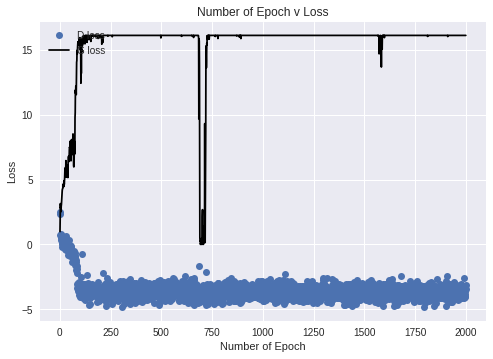

In [15]:
epoch=np.arange(1,2001,1)
fig, ax = plt.subplots()
ax.plot(epoch, train_hist['D_losses'], 'o', label='D loss')
ax.plot(epoch, train_hist['G_losses'], 'k', label='G loss')
legend = ax.legend(loc='upper left')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title('Number of Epoch v Loss')


## Graph 2: @ Epoch 20; 

Text(0.5, 1.0, 'Number of Epoch v Loss')

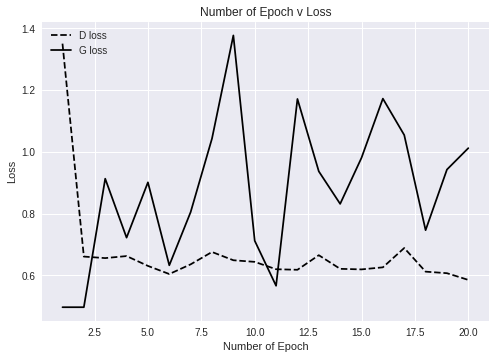

In [56]:
D_losses = [1.35, 0.660609, 0.65567153, 0.6622769, 0.630414009, 0.6041169762, 0.6354942321777, 0.6754931211471558, 0.6487343311309814, 0.643484354019165, 0.619666576385498, 0.617867648601532, 0.6650657057762146, 0.6209251880645752
           ,0.6191090941429138, 0.6258078813552856, 0.6882978081703186, 0.6118475198745728, 0.606818437576294, 0.5850663781166077]
G_losses = [0.4966937005519867,0.4966937005519867 ,0.9127594232559204,0.7218921780586243, 0.9009438753128052, 0.6323416233062744, 0.8046920895576477,1.042804479598999,1.3766385316848755,0.7118204832077026,0.5660661458969116, 1.1708855628967285, 0.9364973306655884,0.8312244415283203 , 0.9804545044898987, 1.1719845533370972
            ,1.0540974140167236,0.7460905313491821, 0.942375659942627, 1.0116865634918213]
epoch=np.arange(1,21,1)

fig, ax = plt.subplots()
ax.plot(epoch, D_losses, 'k--', label='D loss')
ax.plot(epoch, G_losses, 'k', label='G loss')
legend = ax.legend(loc='upper left')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title('Number of Epoch v Loss')


## Graph 3: @ Epoch 2000 
- G loss 

Text(0.5, 1.0, 'Number of Epoch v Loss')

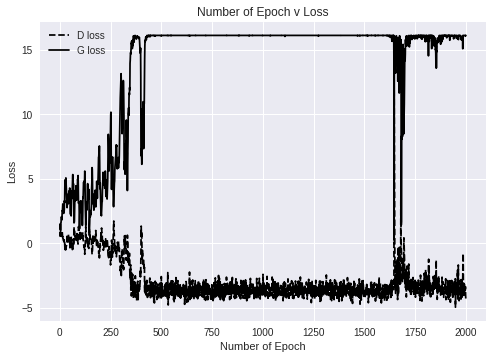

In [27]:
epoch=np.arange(1,2001,1)
fig, ax = plt.subplots()
ax.plot(epoch, train_hist['D_losses'], 'k--', label='D loss')
ax.plot(epoch, train_hist['G_losses'], 'k', label='G loss')
legend = ax.legend(loc='upper left')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title('Number of Epoch v Loss')

## Graph4: @4000 epochs
- from 2000 to 4000 epochs, the images do look better but not completely discernable. 
- loss values are definitely alot more stable 

Text(0.5, 1.0, 'Number of Epoch v Loss')

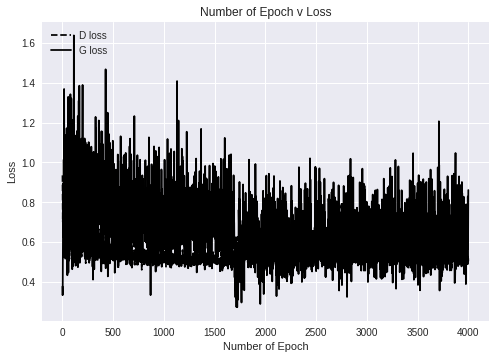

In [6]:
epoch=np.arange(1,4001,1)
fig, ax = plt.subplots()
ax.plot(epoch, train_hist['D_losses'], 'k--', label='D loss')
ax.plot(epoch, train_hist['G_losses'], 'k', label='G loss')
legend = ax.legend(loc='upper left')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title('Number of Epoch v Loss')

##Graph 5: @ epoch 4000 
- removed image flipping

Text(0.5, 1.0, 'Number of Epoch v Loss')

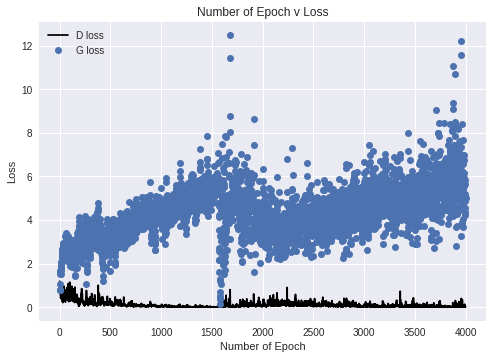

In [12]:
epoch=np.arange(1,4001,1)
fig, ax = plt.subplots()
ax.plot(epoch, train_hist['D_losses'], 'k-', label='D loss')
ax.plot(epoch, train_hist['G_losses'], 'o', label='G loss')
legend = ax.legend(loc='upper left')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title('Number of Epoch v Loss')

##Graph 6: SUCCESS! 
@ 4000 epochs 

- loss still fluctuates but the images look good! 

Text(0.5, 1.0, 'Number of Epoch v Loss')

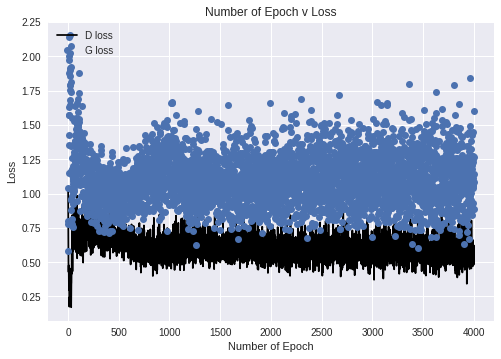

In [37]:
epoch=np.arange(1,4001,1)
fig, ax = plt.subplots()
ax.plot(epoch, train_hist['D_losses'], 'k-', label='D loss')
ax.plot(epoch, train_hist['G_losses'], 'o', label='G loss')
legend = ax.legend(loc='upper left')
plt.xlabel('Number of Epoch')
plt.ylabel('Loss')
plt.title('Number of Epoch v Loss')

##Training the model
1.  first determinee if discirminator model is correct by training it alone 
2. discriminator nad adversarial models trained one after another 


In [0]:
x_train.shape


(60000, 28, 28)

In [0]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
 


In [0]:
x_train = x_train.reshape(-1, 28,28,1).astype(np.float32)
print(x_train.shape)

(55000, 28, 28, 1)


In [0]:
class MNIST_DCGAN(object):
  def __init__(self): 
    self.img_rows = 28 
    self.img_cols = 28 
    self.channel = 1
    self.x_train = input_data.read_data_sets("mnist", one_hot = True).train.images
    self.x_train = self.x_train.reshape(-1, self.img_rows, self.img_cols, 1).astype(np.float32)
    
    self.GAN = GAN()
    self.discriminator = self.GAN.DM()
    self.generator = self.GAN.build_generator() 
    self.AM = self.GAN.AM()
    
  def plt_imgs(self,index): 
    noise = gennoise(16,100)
    fake_imgs = self.DM.predict(noise)
    
    figs,axs = plt.subplots(3,3)
    count = 0 
    for i in range(3): 
      for j in range(3): 
        img = image.array_to_img(fake_imgs[count], scale=True)
        axs[i,j].imshow(img)
        axs[i,j].axis('off')
        count+=1
    plt.show()
    plt.close()
    
  def train(self, train_steps=500, batch_size=256, save_interval=0):
    if save_interval>0: 
      noise_input = np.random.uniform(-1.0, 1.0, size=[16,100])
    for i in range(train_steps): 
      index = np.random.randint(0, self.x_train.shape[0], size=batch_size)
      images_train = self.x_train[index,:,:,:]
      noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
      images_fake = self.generator.predict(noise)
   
      #print(images_fake.shape)
      
      x=np.concatenate((images_train, images_fake))
      #d_loss_real = self.discriminator.train_on_batch(images_train, np.ones(((batch_size), 1)))
      #d_loss_fake = self.discriminator.train_on_batch(images_fake, np.zeros(((batch_size),1)))
      #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      #print(d_loss)
      y=np.ones([2*batch_size, 1])
      y[batch_size:, :]=0
      d_loss = self.discriminator.train_on_batch(x,y)
      
      noise1 = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
      y1 = np.ones([batch_size,1])
      a_loss = self.AM.train_on_batch(noise1,y1)
      log_mesg="%d:[D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
      log_mesg = "%s: [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
      print(log_mesg)
      plt_imgs(index)
      

    
  def plot_imgs(self): 
    plt.figure(figsize=(10,10))
    for i in range(images.shape[0]): 
      plt.subplot(4,4,i+1)
      image = images[i, :, :, :]
      image = np.reshape(image, [self.img_rows, self.img_cols])
      plt.imshow(image, cmap='gray')
      plt.axis('off')
    plt.tight_layout() 
    

In [0]:
if __name__ == '__main__': 
  mnist_dcgan = MNIST_DCGAN()
  mnist_dcgan.train(train_steps=2000, batch_size=256, save_interval=500)
  mnist_dcgan.plot_imgs

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 14, 14, 64)        640       
_________________________________________________________________
batch_normalization_49 (Batc (None, 14, 14, 64)        256       
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 7, 7, 128)         131200    
_________________________________________________________________
batch_normalization_50 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 7, 7, 128)         0         
__________

NameError: ignored

Training the Discriminator Model
 - seems like the model converges too quickly, even after changing depth for Conv2D layers + reducing convolutional filter size 
 - dropout kept at 0.4 

## Parameter tuning 
I. discriminator deep network: depth increases with each convolutional layer <br>
II.  addition of flipped indicies 


x_train shape is (60000, 28, 28)

In [0]:


y=np.ones([batch_size,1])
noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
a_loss = adversarial.train_on_batch(noise,y )